In [1]:
import torch
import torchvision
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
!wget 'https://samplelib.com/lib/preview/wav/sample-15s.wav'

--2024-09-19 20:37:06--  https://samplelib.com/lib/preview/wav/sample-15s.wav
Resolving samplelib.com (samplelib.com)... 188.227.59.182
Connecting to samplelib.com (samplelib.com)|188.227.59.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3382316 (3.2M) [audio/x-wav]
Saving to: ‘sample-15s.wav’

sample-15s.wav      100%[===================>]   3.23M  1.49MB/s    in 2.2s    

2024-09-19 20:37:09 (1.49 MB/s) - ‘sample-15s.wav’ saved [3382316/3382316]



In [3]:
from IPython.display import Audio
Audio('sample-15s.wav')

In [4]:
audio, sampl_freq=torchaudio.load('sample-15s.wav')
print(audio)

tensor([[-0.0620, -0.0316,  0.0812,  ...,  0.0801,  0.0790,  0.0778],
        [-0.0620, -0.0316,  0.0812,  ...,  0.0801,  0.0790,  0.0778]])


In [5]:
print(sampl_freq)
print(audio.shape)

44100
torch.Size([2, 845568])


In [6]:
# it is stereo. we take mono only.
audio=audio[0]
audio.shape

torch.Size([845568])

In [7]:
print(audio)

tensor([-0.0620, -0.0316,  0.0812,  ...,  0.0801,  0.0790,  0.0778])


In [8]:
sampl_no = audio.shape[0]

In [9]:
#trimming down to 1st 5s
trim_audio=audio[:5*sampl_freq]
print(trim_audio.shape)

torch.Size([220500])


In [10]:
def plot_waveform(wave, sample_freq, color, title):
    plt.figure(figsize=(15, 4))
    n=audio.shape[0]
    plt.plot(audio, color=color, alpha=0.7)
    y_pos=np.arange(0,n,sample_freq)
    x_loc=np.arange(0,n/sample_freq,1)
    plt.xticks(y_pos,x_loc)
    plt.xlabel('Time in seconds')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid()
    plt.show()

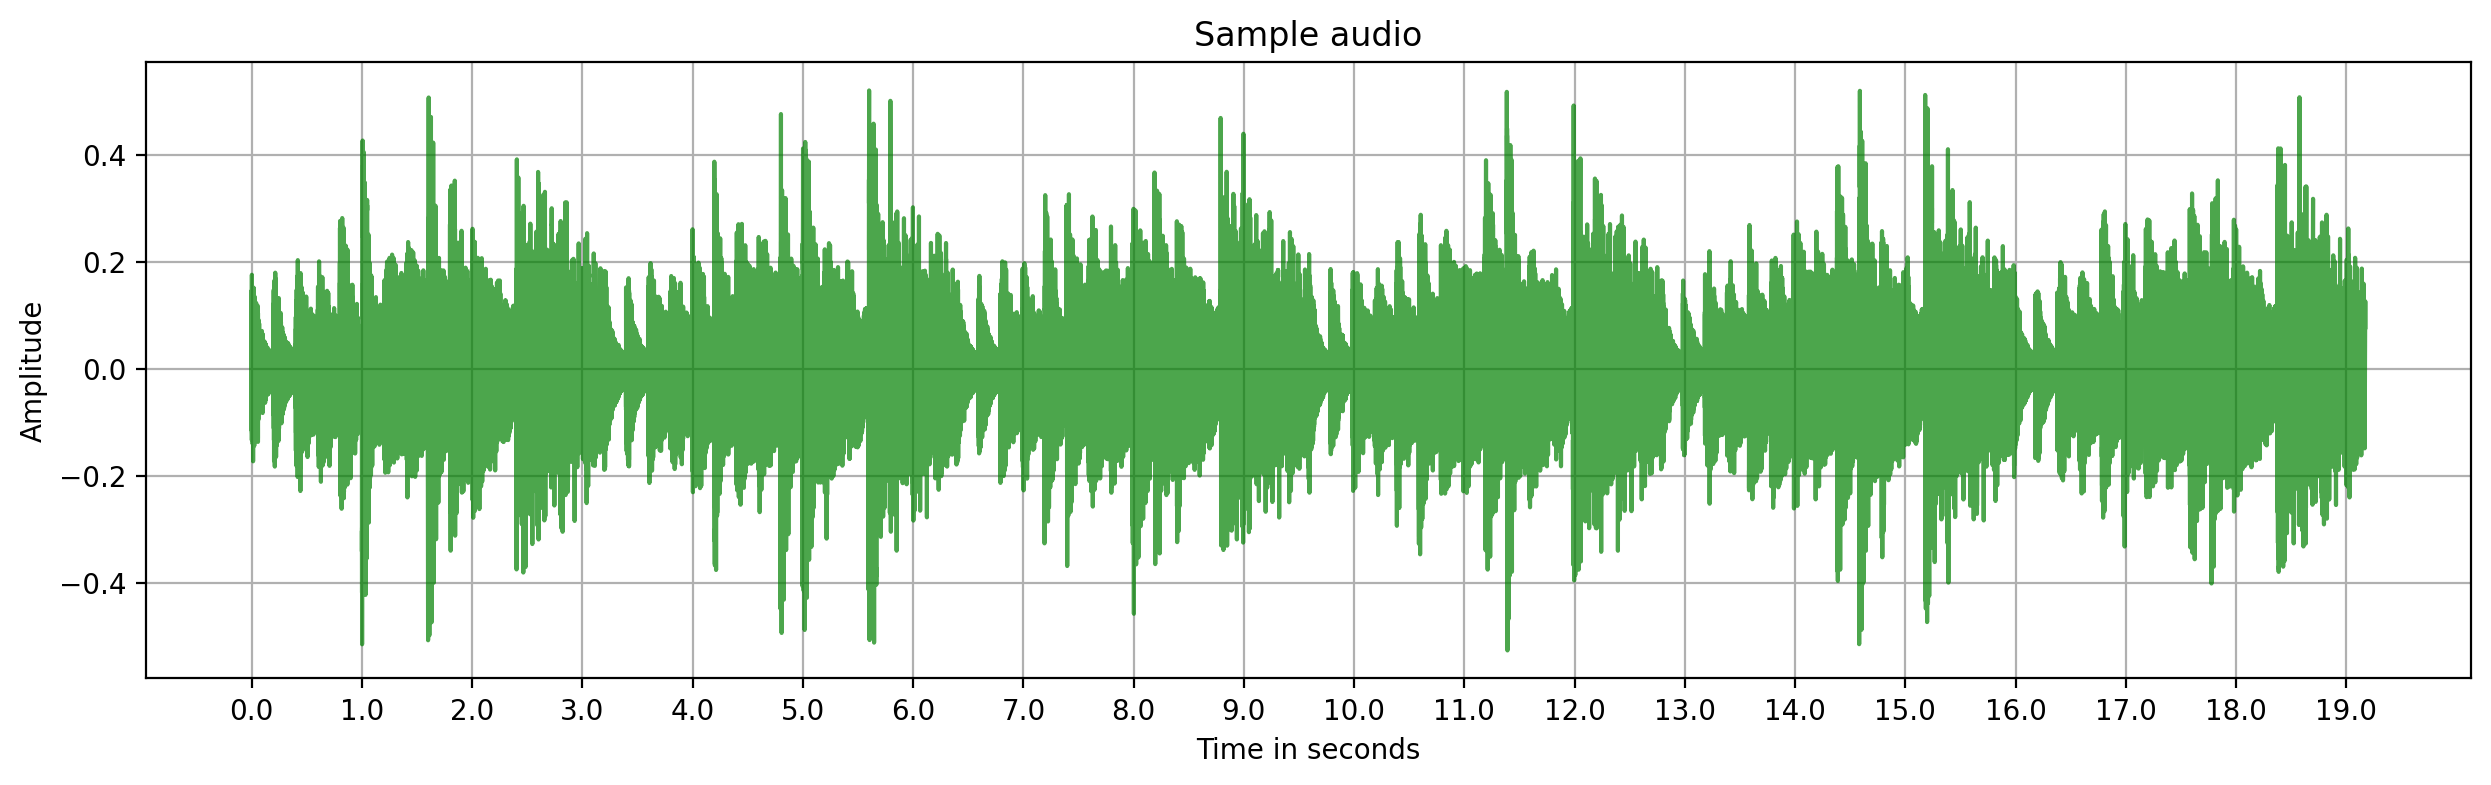

In [11]:
plot_waveform(trim_audio,sampl_freq,'green','Sample audio')

In [12]:
Audio(trim_audio,rate=sampl_freq)

In [13]:
# Creating input feature - time series:
X=torch.arange(0,len(trim_audio))
y=trim_audio

In [14]:
print(X.shape)
print(X)

torch.Size([220500])
tensor([     0,      1,      2,  ..., 220497, 220498, 220499])


In [15]:
X=X.unsqueeze(1).float()
print(X.shape)

torch.Size([220500, 1])


In [16]:
X[-20:]

tensor([[220480.],
        [220481.],
        [220482.],
        [220483.],
        [220484.],
        [220485.],
        [220486.],
        [220487.],
        [220488.],
        [220489.],
        [220490.],
        [220491.],
        [220492.],
        [220493.],
        [220494.],
        [220495.],
        [220496.],
        [220497.],
        [220498.],
        [220499.]])

In [17]:
X_scaled=X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([220500, 1])
tensor([[-100.0000],
        [ -99.9991],
        [ -99.9982],
        ...,
        [  99.9982],
        [  99.9991],
        [ 100.0000]])


In [18]:
def get_rff(X,n,sigma):
    param=1/(2*sigma**2)
    from sklearn.kernel_approximation import RBFSampler
    rff=RBFSampler(n_components=n,gamma=param)
    X=X.numpy()
    X=rff.fit_transform(X)
    return torch.tensor(X,dtype=torch.float32)


In [19]:
X_rff=get_rff(X_scaled,20000,0.008)

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
lin_reg=LinearRegression()

In [23]:
lin_reg.fit(X_rff.numpy(),y.numpy())

LinearRegression()

In [24]:
y_pred=torch.tensor(lin_reg.predict(X_rff.numpy()))

In [25]:
print(y_pred)

tensor([-0.0342, -0.0100,  0.0026,  ...,  0.0594,  0.0572,  0.0327])


In [26]:
Audio(y_pred,rate=sampl_freq)

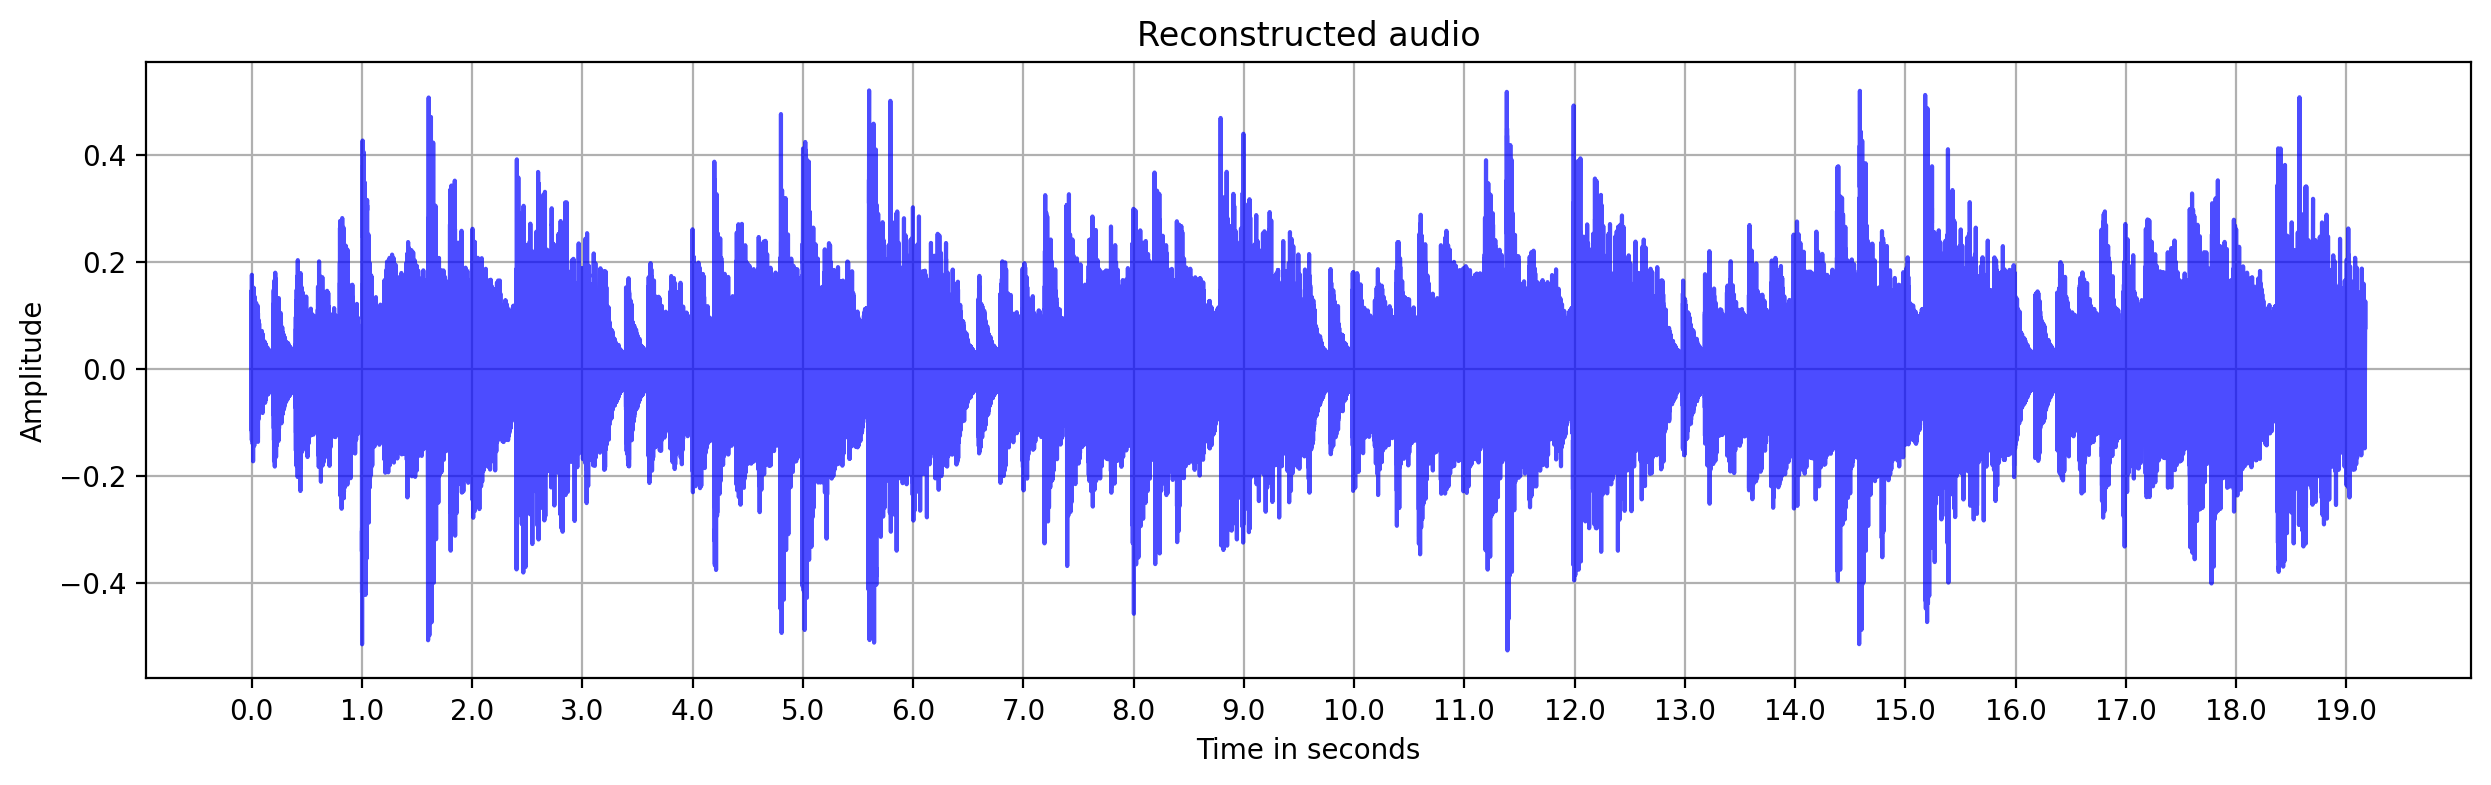

In [28]:
plot_waveform(y_pred,sampl_freq,'blue','Reconstructed audio')

In [29]:
Audio(y,rate=sampl_freq)

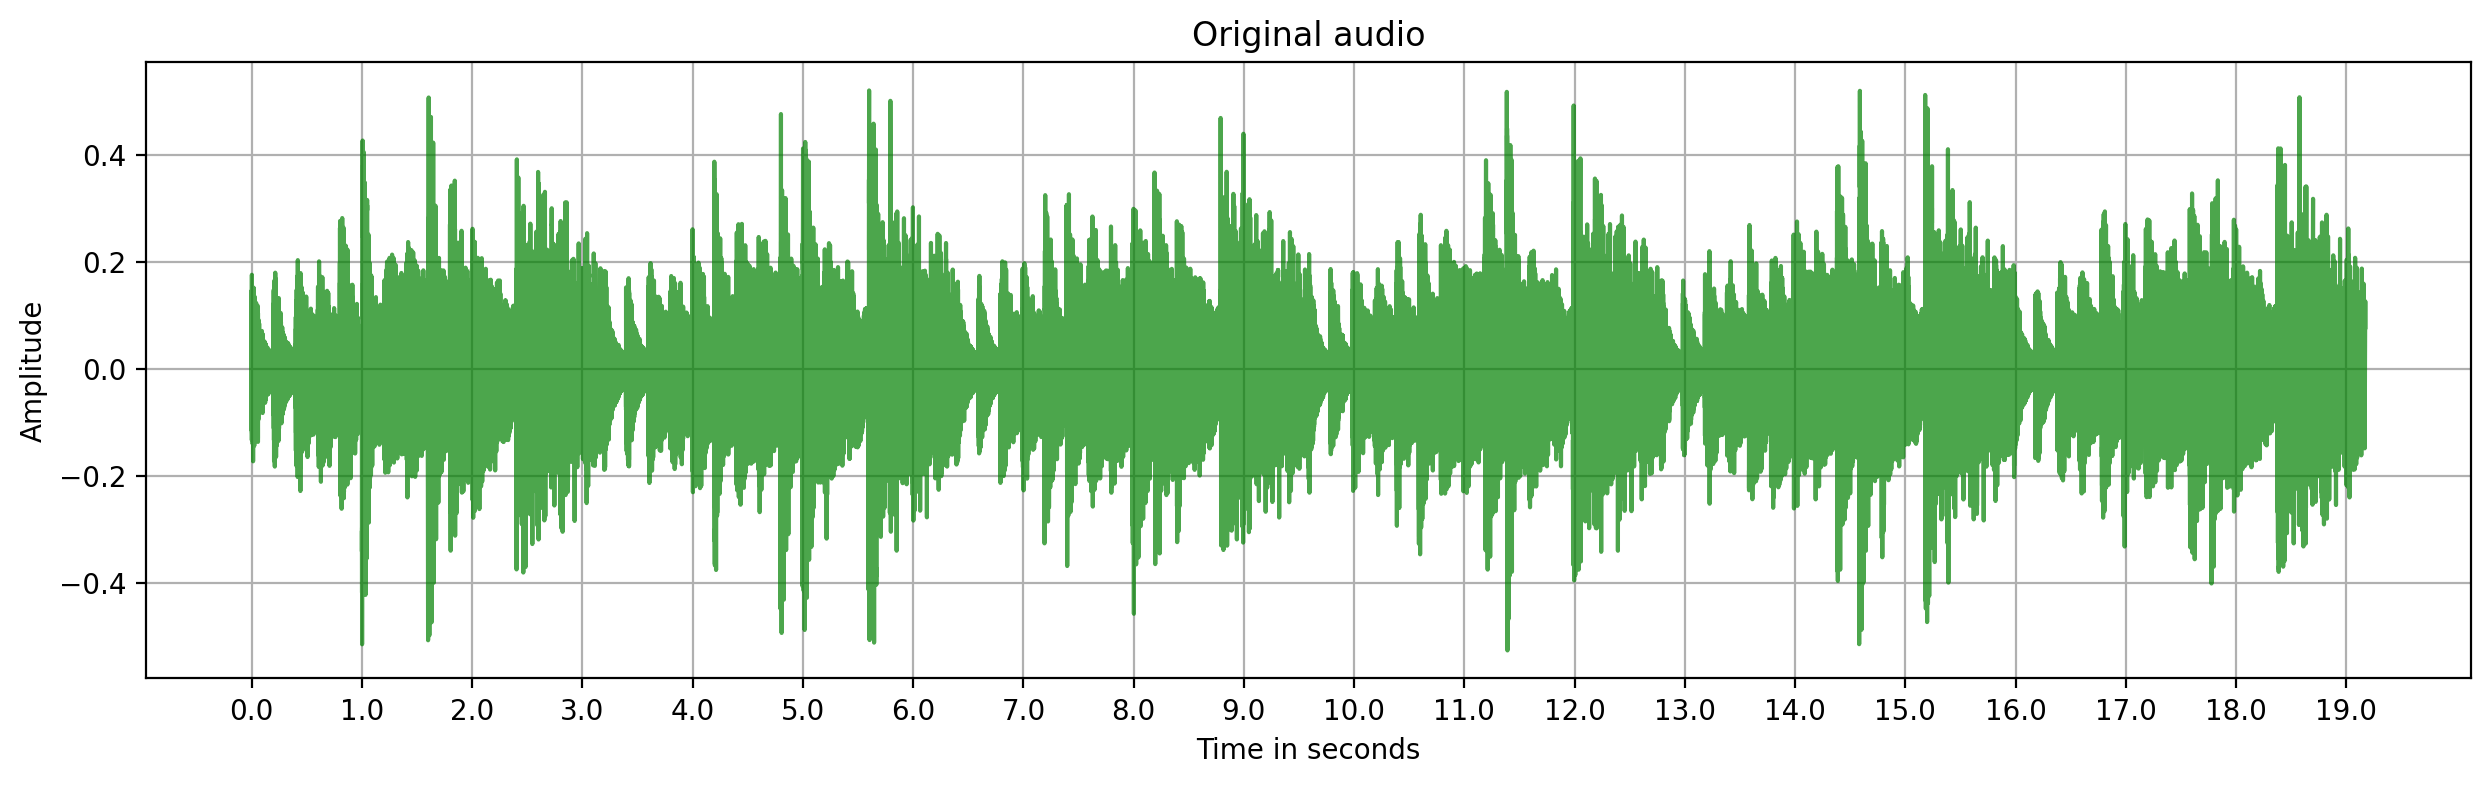

In [30]:
plot_waveform(y,sampl_freq,'green','Original audio')

In [31]:
def get_rmse(orig_audio,reconstr_audio):
  return torch.sqrt(torch.mean((orig_audio-reconstr_audio)**2))

def get_snr(orig_audio,reconstr_audio):
  signal_power=torch.mean(orig_audio**2)
  noise_power=torch.mean((orig_audio-reconstr_audio)**2)
  return 10*torch.log10(signal_power/noise_power)

In [32]:
print("RMSE : ",get_rmse(y,y_pred).item(),"\nSNR : ",get_snr(y,y_pred).item())

RMSE :  0.023404961451888084 
SNR :  11.018538475036621
